# Classification d'opinion avec un Transformer 

Téléchargez les données sur le site d'origine:
[https://ai.stanford.edu/~amaas/data/sentiment/]

Penser à dezipper le fichier d'embeddings présent dans le répertoire data.

Ensuite, le TP est opérationnel :)

In [1]:
# import standard + 
# 
import numpy as np

import torch.nn.functional as F
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

import os
import time
import logging
import re
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print(device)



mps


/var/folders/_h/xz4nr0h53dj3x3tygxjnzl540000gn/T/ipykernel_54921/759565704.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from pathlib import Path
from IPython.display import display, HTML
from torch.utils.tensorboard import SummaryWriter

# Chemin vers TensorBoard
TB_PATH = "/tmp/logs/module-Transf"

# TENSORBOARD 
# usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")
print("Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur")

tensorboard --logdir /tmp/logs/module-Transf
Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur




A. Chargement des données
------------------

Tout le code est fourni. Le cadre est le même que pour la classification de noms: many-to-one. La tâche est de la classification d'opinion (sentiment en anglais)



In [3]:
GLOVE_PATH = Path("data/glove")
DATASET_PATH_TRAIN = Path("data/aclImdb/train")
DATASET_PATH_TEST = Path("data/aclImdb/test")

NB_DOC_MAX = 12500 # par classe
IMDB_CLASSES  = ['neg','pos']
VOC_SIZE = 10000
BATCH_SIZE = 32
MAX_CHAR_SIZE = 1000


labels = dict(zip(IMDB_CLASSES,[0,1]))

def load_data(datapath, classes, max_size=None):
    txts = []
    files = []
    filelabels = []
    for label in classes:
        c = 0
        new = [os.path.join(datapath / label, f) for f in os.listdir(datapath / label) if f.endswith(".txt")]
        files += new
        # filelabels += [labels[label]] * len(new) 
        for file in (datapath / label).glob("*.txt"):
            t = file.read_text()
            txts.append(t if len(t)<MAX_CHAR_SIZE else t[:MAX_CHAR_SIZE])
            filelabels.append(labels[label])
            c+=1
            if max_size !=None and c>=max_size: break

    return txts, files, filelabels
    #     c+=1
    #     if train_max_size !=None and c>train_max_size: break


txts, files, filelabels = load_data(DATASET_PATH_TRAIN, IMDB_CLASSES, max_size = NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data(DATASET_PATH_TEST, IMDB_CLASSES, max_size = NB_DOC_MAX)

In [4]:
print(files[0])
print(txts[0])
print(filelabels[0])
print(len(files),len(txts),len(filelabels))
# labels

data/aclImdb/train/neg/1821_4.txt
Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.
0
25000 25000 25000


## Construction du vocabulaire

On introduit un *tokenizer* pour découper le texte en groupe de lettre. Ce découpage est non trivial (cf cours), on utilise un composant d'analyse venant des libs huggingface

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

# Initialiser un tokenizer WordPiece
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# Définir les pré-traitements
tokenizer.pre_tokenizer = Whitespace()

# Créer un entraîneur avec un vocabulaire cible
trainer = WordPieceTrainer(
    vocab_size=VOC_SIZE,  # Limite du vocabulaire
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)

In [6]:
tokenizer.train(files, trainer)

In [7]:
# Exemple de tokenisation
output = tokenizer.encode("This is an example.", add_special_tokens=True)
print("Tokens:", output.tokens)
print("Token IDs:", output.ids)

# Autre exemple de tokenisation avec des mots plus rares
output = tokenizer.encode("Exemple en francais, loin de la base IMDB")
print("Tokens:", output.tokens)
print("Token IDs:", output.ids)

Tokens: ['This', 'is', 'an', 'example', '.']
Token IDs: [528, 355, 403, 1769, 20]
Tokens: ['Ex', '##em', '##ple', 'en', 'fra', '##n', '##c', '##ai', '##s', ',', 'lo', '##in', 'de', 'la', 'base', 'IMD', '##B']
Token IDs: [2589, 433, 642, 499, 4872, 192, 185, 2657, 182, 18, 5948, 332, 475, 4213, 3939, 2765, 205]


Récupération des indices de tokens spéciaux

In [8]:
PAD = tokenizer.encode("[PAD]").ids[0]
print("PAD",PAD)

CLS = tokenizer.encode("[CLS]").ids[0]
print("CLS",CLS)

EOS = tokenizer.encode(".").ids[0]
print("EOS", EOS)

PAD 3
CLS 1
EOS 20


In [9]:
# fabrication de tous les codes (+ astuce pour ajouter les CLS)

allcodes = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in txts]
allcodes_test = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in txts_test]

### Chaine de traitement

1. Récupération des données avec un Dataset
2. Construction du dataloader

On se place dans une logique générative: on ne fait pas d'ensemble de test (c'est discutable)


In [10]:
from torch.utils.data import Dataset, DataLoader
import sys
import re

class TextDataset(Dataset):
    def __init__(self, texts: list, labels):
        self.labels = labels
        self.phrasesnum = texts

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.phrasesnum[i], torch.tensor(self.labels[i])



In [11]:
ds_train = TextDataset(allcodes,filelabels)
ds_test  = TextDataset(allcodes_test,filelabels_test)

In [12]:

print("longueur:", len(ds_train))
print("doc 0: ", ds_train[0])
print("doc 1: ", ds_train[1])
print("doc 2: ", ds_train[2])

# savez-vous retrouver les token EOS/.?

longueur: 25000
doc 0:  (tensor([   1, 2278, 2909,  402,  454,  347,  331,  783, 4286, 5873,  182,   18,
         381,  397, 3000,  346,  365, 3160,  563,  346,  363,   13,   89, 5873,
          18, 5539,  827, 5490,  346,   71, 4146,  180, 1331,  417,  354,  391,
         354,  357, 6225, 5703,  331,  397,  487,  824, 9081, 9786,  183,   13,
          89, 7126,   18,  344,  553,   13,   89,   71, 3024,  851,  372,  531,
        1593,   20]), tensor(0))
doc 1:  (tensor([   1, 1418,  588, 2554, 6509,  180,  182,   47,   18,  331,  995, 2178,
         659,  351, 7554,  344,   79, 1168,  331,  409,  979, 2402,  346,  545,
          20, 1641,   18,  485, 4843,  342,  346,  679, 2554, 6509,  180,  182,
        3288,  344, 7560,   20, 8703,  370,  509,   18,  883,  707, 2178,  916,
        9539, 1000,  749,  485, 4527,  331,  680,  454,   18,   79, 1214,   18,
        1436, 8463,  421, 4385, 1815,   18,  575, 1926, 1346,  355, 5474,  347,
        4173,  338,  331, 2373,    8,  936,  351, 192

In [13]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=False)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



In [14]:
# Test

batch =next(iter( train_loader))
padded_sequences, lengths, labels = batch
print("Padded sequences:", padded_sequences)
print(padded_sequences.size())
# print("Lengths:", lengths)
print("Labels:", labels)


Padded sequences: tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [5415,   47,   79,  ..., 5250, 1135, 5094],
        [5565, 3637,  388,  ...,  187, 1075,  621],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])
torch.Size([286, 32])
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0])


## C. Création du réseau

1. Comprendre les positional embeddings
    - prendre le temps d'afficher les dimensions et de comprendre comment ils vont être utilisés
    - activer ou ne pas activer le gradient???
    
2. Construire le réseau

In [15]:
import math
def generate_sinusoidal_embeddings(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

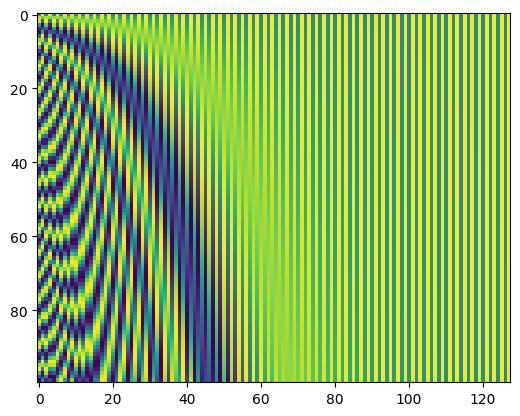

In [16]:
import matplotlib.pyplot as plt

pe = generate_sinusoidal_embeddings(100, 128)

plt.figure()
plt.imshow(pe.numpy())


In [17]:

class TransSent(nn.Module):
    def __init__(self, emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size, maxlen=1000):
        super(TransSent, self).__init__()

        self.emb_size = emb_size

        self.emb = nn.Embedding(voc_size, emb_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, 
            nhead=num_heads, 
            dim_feedforward=hidden_size_mlp,
            activation='relu'
        )

        # Création d'un TransformerEncoder avec plusieurs couches
        self.trans = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Attention, seuls les modules sont envoyés vers les devices
        # pour envoyer automatiquement les tenseurs, il faut les "enregistrer"
        self.register_buffer("posemb", generate_sinusoidal_embeddings(maxlen, self.emb_size).unsqueeze(1))

        # du CLS vers la classif
        self.h2o = nn.Linear(emb_size, output_size)

   
    def forward(self, input, lengths=None):
        # Principales étapes
        # 1. translation of the input from int to emb
        # 2. Passage dans le trans
        # 3. Prediction sur le CLS

        # print("input", input.size())
        maxlen = input.size(0)
        batch_size = input.size(1)

        # A analyser (et à utiliser plus tard)
        padding_mask = (input[:, :] == PAD).T 

        # 1. translation of the input from int to emb + ajout des positional embeddings
        # <CORRECTION>
        xemb = self.emb(input) 
        # print("coucou", xemb.size(),pe.size())
        xemb += self.posemb[:maxlen,:,:]
        # print("xemb", xemb.size())
        # </CORRECTION>
        
        # 2. Passage dans le transformer... Avec le masque pour le padding
        encoded_output = self.trans(xemb, src_key_padding_mask=padding_mask)
        # print("encoded_output", encoded_output.size())
        
        # 3. Appliquer la classification sur le CLS
        # <CORRECTION>
        output = self.h2o(encoded_output[0,:,:]).squeeze(0)
        # </CORRECTION>
        
        return output



In [18]:

# choose hidden size
emb_size = 128
voc_size = VOC_SIZE
num_layers = 1
num_heads = 1
hidden_size_mlp = 128
output_size = 2
# build network
transf = TransSent( emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size)
transf.name = "TransSent-"+time.asctime()

/Users/vguigue/opt/anaconda3/envs/pyth-torch-numpy/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [19]:
loss = nn.CrossEntropyLoss()
# batch
x, lengths, y = next(iter(train_loader))
print(x.size(),y.size())


yhat = transf(x)
print(yhat.size())
l = loss(yhat,y)

torch.Size([279, 32]) torch.Size([32])
torch.Size([32, 2])


## C. Training

1. put the data into a DataLoader
2. choose a loss function 
3. run a standard training loop

In [20]:
# définition de la métrique d'évaluation
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

In [21]:

    
def train(model,epochs,train_loader,test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(model.parameters(),lr=5e-4)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    # 
    # loss = nn.CrossEntropyLoss(weight=cl_weight.to(device))                            # choix loss
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x, lengths, y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)


In [22]:
# ~10 minutes sur CPU
n_epoch = 20
train(transf, n_epoch, train_loader, test_loader)


running TransSent-Tue Jan 14 13:02:02 2025


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
import os

def save_model(model,fichier): # pas de sauvegarde de l'optimiseur ici
      """ sauvegarde du modèle dans fichier """
      state = {'model_state': model.state_dict()}
      torch.save(state,fichier) # pas besoin de passer par pickle
 
def load_model(fichier,model):
      """ Si le fichier existe, on charge le modèle  """
      if os.path.isfile(fichier):
          state = torch.load(fichier)
          model.load_state_dict(state['model_state'])
      else:
           print("Erreur de chargement du fichier")

In [24]:
# sauvegarde du modèle

path = "./"
fichier = path+f"model/{transf.name}"
save_model(transf.to("cpu"),fichier)

In [ ]:

# Creation de la coquille pour charger le modèle
emb_size = 128
voc_size = VOC_SIZE
num_layers = 1
num_heads = 1
hidden_size_mlp = 128
output_size = 2
# build network
transf = TransSent( emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size)

# chargement
path = "./"
fichier = path+f"model/TransSent-1H-1L"

load_model(fichier,transf)

## D. Amélioration de l'architecture et analyse des résultats

1. Tester l'augmentation du nombre de têtes
2. Analyse la forme des attentions, comment trouver les mots qui contrinuent le plus au diagnostic?
3. Utiliser TensorBoard pour visualiser les représentations de mots

In [ ]:
# essais qualitatifs
# tester le modèle sur des exemples de chaines de caractères 
# (oblige à faire la tokenisation + CLS)



In [ ]:
# Afficher le texte des messages sur lesquels on fait des erreurs

In [ ]:
# Afficher la matrice d'attention (ou seulement la ligne CLS) pour une entrée

In [ ]:
# utiliser tensorboard pour afficher en 2D les embeddings des mots

# Construction du sujet à partir de la correction

In [56]:
### <CORRECTION> ###
import re
# transformation de cet énoncé en version étudiante

fname = "5_1_transf_classif-corr.ipynb" # ce fichier
fout  = fname.replace("-corr","")

# print("Fichier de sortie: ", fout )

f = open(fname, "r")
txt = f.read()
 
f.close()

f2 = open(fout, "w")
f2.write(re.sub("<CORRECTION>.*?(</CORRECTION>)"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###